In [15]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
from scipy import cluster as scl
from scipy import stats, integrate
from matplotlib import pyplot as plt
from matplotlib import gridspec as gs
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import seaborn.apionly as sns
import itertools
from nilearn import plotting as nplt

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
# load
%matplotlib inline
%load_ext rpy2.ipython
%load_ext oct2py.ipython
sns.set(color_codes=True)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The oct2py.ipython extension is already loaded. To reload it, use:
  %reload_ext oct2py.ipython


In [18]:
#  Set path
path_root = '/media/yassine/data_disk/Drive/HCP2/subtypes_scores/26-10-2016/'
path_association =  os.path.join(path_root,'subtype_5_spm_EMOTION_03-Oct-2017/associations/')
path_networks =  os.path.join(path_root,'subtype_5_spm_EMOTION_03-Oct-2017/networks/')

In [19]:
mat_file = os.path.join(path_networks,'contrast_fear_vs_neut/stack_contrast_fear_vs_neut.mat')
%octave_push mat_file
%octave mat_load = load(mat_file);
%octave_pull mat_load

In [20]:
mat_load.stack.shape

(774, 59900)

In [21]:
coeff_corr = np.corrcoef(mat_load.stack)

In [9]:
coeff_corr.min()

-0.51714307154579009

In [22]:
import numpy as np

# number of rows in one chunk
SPLITROWS = 1000

# the big table, which is usually bigger
bigdata =mat_load.stack

numrows = bigdata.shape[0]

# subtract means form the input data
bigdata -= np.mean(bigdata, axis=1)[:,None]

# normalize the data
bigdata /= np.sqrt(np.sum(bigdata*bigdata, axis=1))[:,None]

# reserve the resulting table onto HDD
res = np.memmap("/tmp/mydata.dat", 'float64', mode='w+', shape=(numrows, numrows))

for r in range(0, numrows, SPLITROWS):
    for c in range(0, numrows, SPLITROWS):
        r1 = r + SPLITROWS
        c1 = c + SPLITROWS
        chunk1 = bigdata[r:r1]
        chunk2 = bigdata[c:c1]
        res[r:r1, c:c1] = np.dot(chunk1, chunk2.T)

In [153]:
%%R
pkgs <- c("factoextra",  "NbClust")
install.packages(pkgs)

--- Please select a CRAN mirror for use in this session ---


In [ ]:
%%R
library(factoextra)
library(NbClust)

%%R -i coeff_corr
# Elbow method
fviz_nbclust(coeff_corr, kmeans, method = "wss") +
    geom_vline(xintercept = 4, linetype = 2)+
  labs(subtitle = "Elbow method")

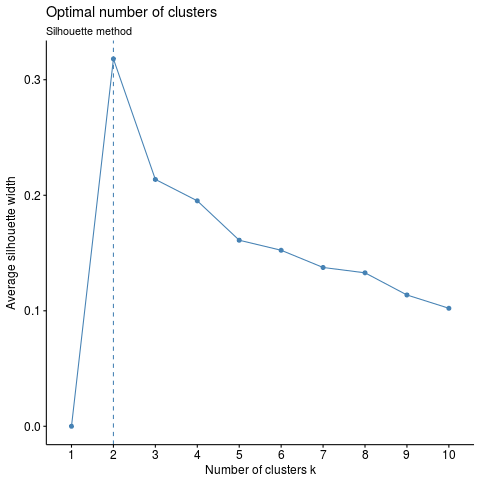

In [25]:
%%R -i coeff_corr
# Silhouette method
fviz_nbclust(coeff_corr, kmeans, method = "silhouette")+
  labs(subtitle = "Silhouette method")

Clustering k = 1,2,..., K.max (= 10): .. done
Bootstrapping, b = 1,2,..., B (= 50)  [one "." per sample]:
.................................................. 50 


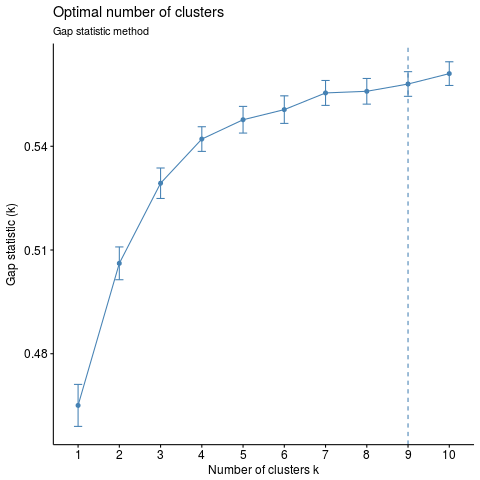

In [26]:
%%R -i coeff_corr

# Gap statistic
# nboot = 50 to keep the function speedy. 
# recommended value: nboot= 500 for your analysis.
# Use verbose = FALSE to hide computing progression.
set.seed(123)
fviz_nbclust(coeff_corr, kmeans, nstart = 2,  method = "gap_stat", nboot = 50)+
  labs(subtitle = "Gap statistic method")


In [20]:
%%R -i coeff_corr
nb <- NbClust(coeff_corr, distance = "euclidean", min.nc = 2,
        max.nc = 10, method = "kmeans")

fviz_nbclust(nb)


Error in NbClust(coeff_corr, diss = "NULL", distance = "euclidean", min.nc = 2,  : 
  The TSS matrix is indefinite. There must be too many missing values. The index cannot be calculated.


In [30]:
%matplotlib inline
import time
import hashlib
import scipy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

plt.rcParams['figure.figsize'] = 10, 10

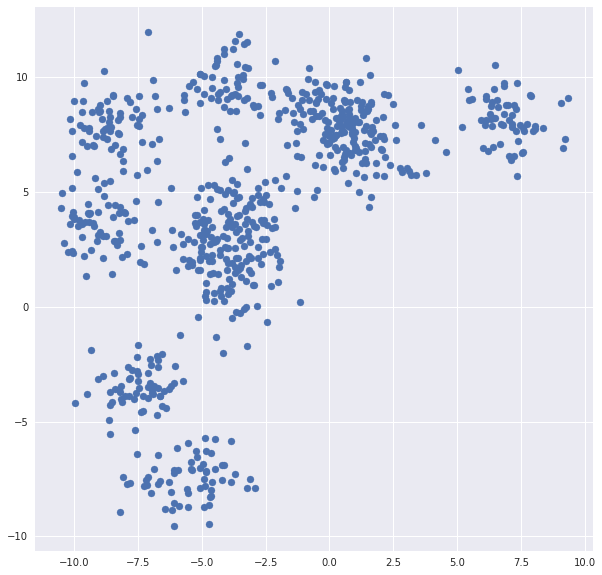

In [22]:
x, y = make_blobs(750, n_features=2, centers=12)

plt.scatter(x[:, 0], x[:, 1])
plt.show()


In [31]:
def optimalK(data, nrefs=3, maxClusters=15):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):

        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)

        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp

        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_

        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)

        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)

    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal
    

In [32]:
k, gapdf = optimalK(coeff_corr, nrefs=5, maxClusters=40)
print ('Optimal k is: ', k)

Optimal k is:  39


In [ ]:
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [29]:
coeff_corr.shape

(774, 774)

In [ ]:
%%R -i coeff_corr
# Elbow method
fviz_nbclust(coeff_corr, kmeans, method = "wss") +
    geom_vline(xintercept = 4, linetype = 2)+
  labs(subtitle = "Elbow method")
# Silhouette method
fviz_nbclust(coeff_corr, kmeans, method = "silhouette")+
  labs(subtitle = "Silhouette method")
# Gap statistic
# nboot = 50 to keep the function speedy. 
# recommended value: nboot= 500 for your analysis.
# Use verbose = FALSE to hide computing progression.
set.seed(123)
fviz_nbclust(coeff_corr, kmeans, nstart = 25,  method = "gap_stat", nboot = 50)+
  labs(subtitle = "Gap statistic method")

In [145]:
# Calculate Mojena clustering cut-off
R=res
nc = R.shape[1]-1
for i in range(0,nc):
    abar = np.mean(R[:i+1,i])
    astd = np.std(R[:i+1,i])
    d_s = abar+astd
    if d_s < R[i+1,i]:
        break

# Number of subtypes
n_sbt= i+1;
print('The cut-off cluster is {}'.format(n_sbt))


The cut-off cluster is 106


In [143]:
res.max

<function memmap.max>

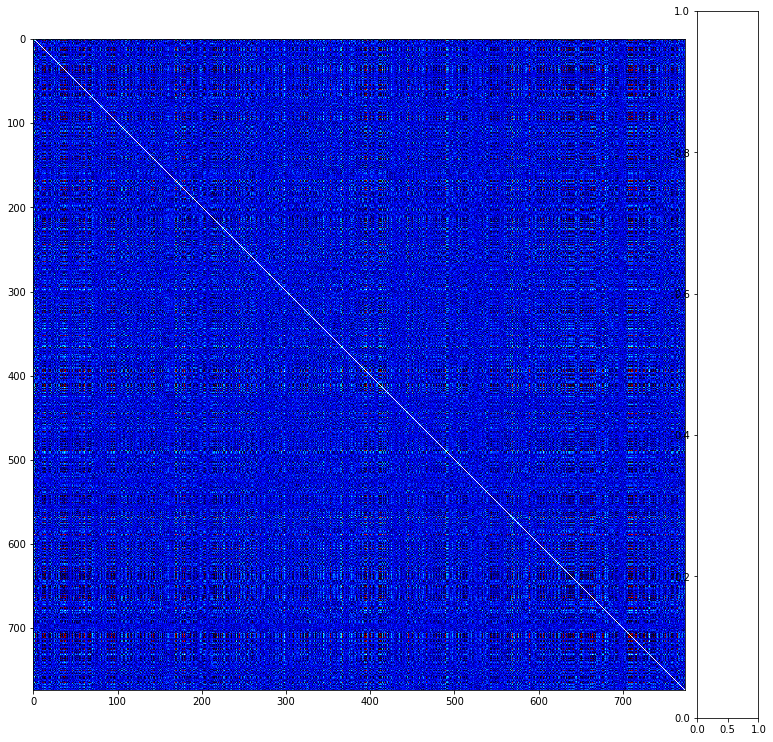

In [142]:
gsp = gs.GridSpec(1, 10)
f = plt.figure(figsize=(13,13))
ax = f.add_subplot(gsp[0,:9])
axcl = f.add_subplot(gsp[0,9])
p = ax.imshow(res,cmap = nplt.cm.cold_hot)

In [52]:
for key in d.items():

dict_keys

In [57]:
dict = {'Name': 'Zara', 'Age': 7, 'Class': 'First'}

In [53]:
f = open('store.txt', 'rU')
for line in f:   ## iterates over the lines of the file
    dict_new = '{},'.format(line)   ## trailing , so print does not add an end-of-line char
f.close()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 'U' mode is deprecated
  """Entry point for launching an IPython kernel.


In [56]:
dict_new

"               'Strength_Unadj']}\n,"

In [62]:
d2.items()

dict_items([('Cluster_4', ['PSQI_Score', 'FearSomat_Unadj', 'PainInterf_Tscore', 'ASR_Soma_Pct', 'DSM_Somp_Pct']), ('Cluster_9', ['CardSort_Unadj', 'Flanker_Unadj', 'ProcSpeed_Unadj', 'Endurance_Unadj', 'Strength_Unadj']), ('Cluster_2', ['Sadness_Unadj', 'FearAffect_Unadj', 'AngHostil_Unadj', 'AngAffect_Unadj', 'Loneliness_Unadj', 'PercHostil_Unadj', 'PercReject_Unadj', 'PercStress_Unadj', 'NEOFAC_N']), ('Cluster_7', ['ASR_Anxd_Pct', 'ASR_Witd_Pct', 'ASR_Thot_Pct', 'ASR_Attn_Pct', 'ASR_Intn_T', 'DSM_Depr_Pct', 'DSM_Anxi_Pct', 'DSM_Avoid_Pct', 'DSM_Adh_Pct']), ('Cluster_10', ['SSAGA_Educ', 'PMAT24_A_CR', 'PMAT24_A_RTCR', 'ReadEng_Unadj', 'PicVocab_Unadj', 'DDisc_AUC_200', 'DDisc_AUC_40K', 'VSPLOT_TC', 'NEOFAC_O']), ('Cluster_8', ['PicSeq_Unadj', 'SCPT_TP', 'SCPT_TN', 'IWRD_TOT', 'ER40_CR', 'Taste_Unadj', 'Odor_Unadj', 'Mars_Final', 'GaitSpeed_Comp', 'Dexterity_Unadj']), ('Cluster_6', ['LifeSatisf_Unadj', 'MeanPurp_Unadj', 'PosAffect_Unadj', 'Friendship_Unadj', 'EmotSupp_Unadj', 'InstruS

In [59]:
dict.keys()

dict_keys(['Age', 'Name', 'Class'])